# Project - Building a MovieLens Recommender System Using Graphs

### Source of Data - MovieLens

[MovieLens](https://grouplens.org/datasets/movielens/) is the data used in this project to test and train the recommendation system. It was developed by GroupLens, a computer science research lab at the University of Minnesota. It recommends movies to its users based on their movie ratings.

In [338]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils.dataloader import DataLoader 

### 1. Data load

In [359]:
# Define the dataset size (100k or 1m)
dataset_size = "100k"  # You can also use "1m" for a larger dataset

# Ensure files are downloaded, if not already present
movie_data = DataLoader(size=dataset_size)

# Load rating data
rating_df = movie_data.load_ratings()

# Load movie data
movie_df = movie_data.load_items(
    process_title=True, process_year=True, process_genres=True, genres_as_binary=False)

# Load user data
user_df= movie_data.load_user_features(True, True)

# Load actors and directors data
fetched_movies = pd.read_csv("./data/fetched_movies.csv")
semantics_info = fetched_movies[['MovieLens_ID', 'Director', 'Actors']]

# Display sample data
print("Ratings Data:", len(rating_df))
print(rating_df.head())
print("\nMovie Data:", len(movie_df))
print(movie_df.head())
if user_df is not None:
    print("\nUser Data:", len(user_df))
    print(user_df.head())

Ratings Data: 100000
   user  item  rating  timestamp
0   196   242       3  881250949
1   186   302       3  891717742
2    22   377       1  878887116
3   244    51       2  880606923
4   166   346       1  886397596

Movie Data: 1682
   movie_id       title  year                       genres
0         1   Toy Story  1995  Animation|Children's|Comedy
1         2   GoldenEye  1995    Action|Adventure|Thriller
2         3  Four Rooms  1995                     Thriller
3         4  Get Shorty  1995          Action|Comedy|Drama
4         5     Copycat  1995         Crime|Drama|Thriller

User Data: 943
   userid    age gender  occupation zipcode
0       1  18-24      M          19   85711
1       2  50-55      F          13   94043
2       3  18-24      M          20   32067
3       4  18-24      M          19   43537
4       5  25-34      F          13   15213


### 2. Data Analysis with Graph Science ####
Firstly, we explore the graph structure of the data to help infer an appropriate model structure for later stages.

In [360]:
rating_df.columns

Index(['user', 'item', 'rating', 'timestamp'], dtype='object')

In [361]:
from scipy.sparse import csr_matrix

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe containing 3 columns (user, movieId, rating)
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    M = df['user'].nunique()
    N = df['item'].nunique()

    user_mapper = dict(zip(np.unique(df["user"]), list(range(M))))
    movie_mapper = dict(zip(np.unique(df["item"]), list(range(N))))
    
    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["user"])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["item"])))
    
    user_index = [user_mapper[i] for i in df['user']]
    item_index = [movie_mapper[i] for i in df['item']]

    X = csr_matrix((df["rating"], (user_index,item_index)), shape=(M,N))
    
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(rating_df)

#### Evaluating sparsity

Here, we calculate sparsity by dividing the number of stored elements by total number of elements. The number of stored (non-empty) elements in our matrix ([nnz](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.nnz.html)) is equivalent to the number of ratings in our dataset.

In [362]:
n_total = X.shape[0]*X.shape[1]
n_ratings = X.nnz
sparsity = n_ratings/n_total
print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 6.3%


Only 6.3% of all possible connections are observed in the data, highlighting the significance of the cold start problem in improving prediction accuracy.
The **cold start problem** is when there are new users and movies in our matrix that do not have any ratings. In our Movielens dataset, all users and movies have at least one rating but in general, it's useful to check which users and movies have few interactions.

In [363]:
n_ratings_per_user = X.getnnz(axis=1)
len(n_ratings_per_user)

943

In [364]:
print(f"Most active user rated {n_ratings_per_user.max()} movies.")
print(f"Least active user rated {n_ratings_per_user.min()} movies.")
print(f"On average, an user would rate {round(n_ratings_per_user.mean())} movies.")

Most active user rated 737 movies.
Least active user rated 20 movies.
On average, an user would rate 106 movies.


In [365]:
n_ratings_per_movie = X.getnnz(axis=0)
len(n_ratings_per_movie)

1682

In [366]:
print(f"Most rated movie has {n_ratings_per_movie.max()} ratings.")
print(f"Least rated movie has {n_ratings_per_movie.min()} ratings.")
print(f"On average, a movie has {round(n_ratings_per_movie.mean())} ratings.")

Most rated movie has 583 ratings.
Least rated movie has 1 ratings.
On average, a movie has 59 ratings.


/var/folders/9_/rwbmnd2917s2ynq8fvvlmq_80000gn/T/ipykernel_20827/3364525973.py:3: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/var/folders/9_/rwbmnd2917s2ynq8fvvlmq_80000gn/T/ipykernel_20827/3364525973.py:9: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




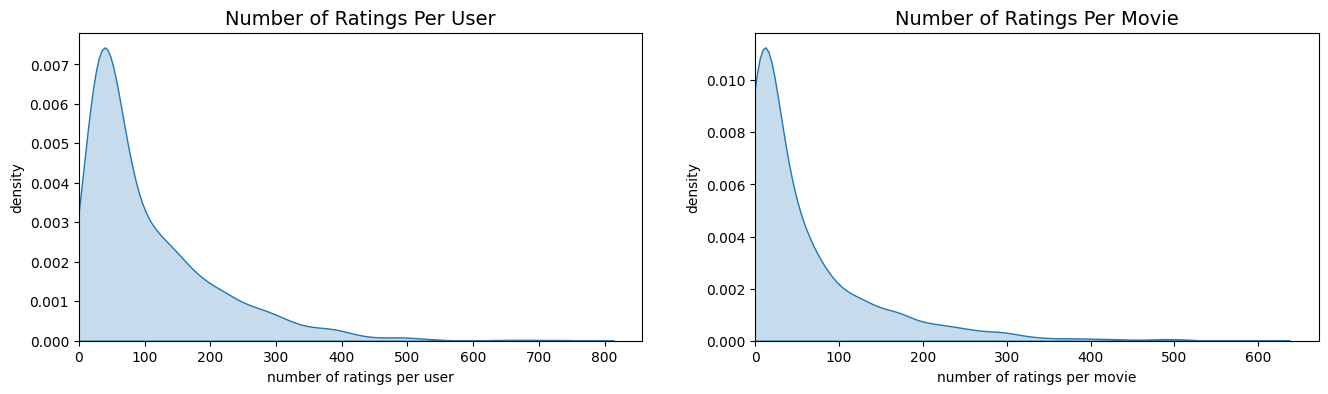

In [367]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.kdeplot(n_ratings_per_user, shade=True)
plt.xlim(0)
plt.title("Number of Ratings Per User", fontsize=14)
plt.xlabel("number of ratings per user")
plt.ylabel("density")
plt.subplot(1,2,2)
sns.kdeplot(n_ratings_per_movie, shade=True)
plt.xlim(0)
plt.title("Number of Ratings Per Movie", fontsize=14)
plt.xlabel("number of ratings per movie")
plt.ylabel("density")
plt.show()

The analysis above suggests that the cold start problem is quite severe due to the highly right-skewed distributions. Therefore, it indicates that implementing content filtering recommendation techniques is essential to enhance prediction accuracy.

### 3. A Glimpse at Movies data

A movie can be characterized by different genres. The raw data is not yet processed so we could analyze it. Once the genre data is cleaned up, we will explore what information we could derive from movie genres.

In [368]:
movie_df.columns

Index(['movie_id', 'title', 'year', 'genres'], dtype='object')

In [369]:
movie_df['genres']

0       Animation|Children's|Comedy
1         Action|Adventure|Thriller
2                          Thriller
3               Action|Comedy|Drama
4              Crime|Drama|Thriller
                   ...             
1677                          Drama
1678               Romance|Thriller
1679                  Drama|Romance
1680                         Comedy
1681                          Drama
Name: genres, Length: 1682, dtype: object

#### (1) What is the distribution of movie release years?

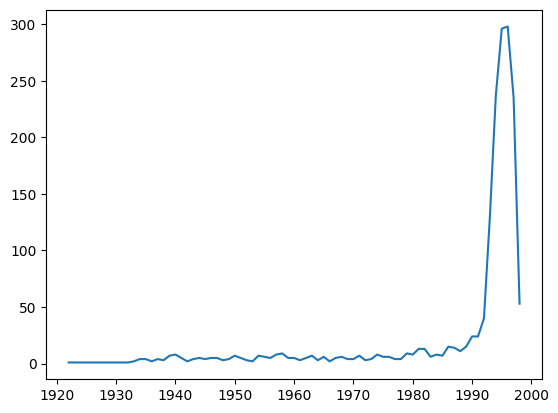

Max No.of Movies Relesed = 298
year = 1996


count     71.000000
mean      23.676056
std       62.458849
min        1.000000
25%        4.000000
50%        5.000000
75%        8.000000
max      298.000000
Name: title, dtype: float64

In [370]:
#Ploting a Graph with No.of Movies each Year corresponding to its Year
plt.plot(movie_df.groupby('year').title.count())
plt.show()
a=movie_df.groupby('year').title.count()
print('Max No.of Movies Relesed =',a.max())
for i in a.index:
    if a[i] == a.max():
        print('year =',i)
a.describe()

As the above result we got to know that in 1996 has the highest number of movie releases with 298 Movies. On an Avg. there are around 23 Movies releasing per Year.

#### (2) What is the distribution of movie genres?

A movie can be characterized by different genres. The raw data is not yet processed so we could analyze it. Once the genre data is cleaned up, we will explore what information we could derive from movie genres.

In [371]:
# Merge ratings with user data
movie_df.rename(columns={'movie_id': 'item'}, inplace=True)
ratings_with_movies = pd.merge(rating_df, movie_df, on='item', how='left')

In [372]:
ratings_with_movies['genres']

0                                  Comedy
1        Crime|Film-Noir|Mystery|Thriller
2                       Children's|Comedy
3               Drama|Romance|War|Western
4                             Crime|Drama
                       ...               
99995                              Comedy
99996                       Comedy|Sci-Fi
99997                            Thriller
99998                   Children's|Comedy
99999                             Western
Name: genres, Length: 100000, dtype: object

In [373]:
ratings_with_movies['genres'] = ratings_with_movies['genres'].apply(lambda x: x.split("|"))
ratings_with_movies.head()

,user,item,rating,timestamp,title,year,genres
0,196,242,3,881250949,Kolya,1996,[Comedy]
1,186,302,3,891717742,L.A. Confidential,1997,"[Crime, Film-Noir, Mystery, Thriller]"
2,22,377,1,878887116,Heavyweights,1994,"[Children's, Comedy]"
3,244,51,2,880606923,Legends of the Fall,1994,"[Drama, Romance, War, Western]"
4,166,346,1,886397596,Jackie Brown,1997,"[Crime, Drama]"


In [375]:
from collections import Counter

genre_frequency = Counter(g for genres in ratings_with_movies['genres'] for g in genres)

print(f"There are {len(genre_frequency)} genres in total in this dataset.")

genre_frequency

There are 19 genres in total in this dataset.


Counter({'Drama': 39895,
         'Comedy': 29832,
         'Action': 25589,
         'Thriller': 21872,
         'Romance': 19461,
         'Adventure': 13753,
         'Sci-Fi': 12730,
         'War': 9398,
         'Crime': 8055,
         "Children's": 7182,
         'Horror': 5317,
         'Mystery': 5245,
         'Musical': 4954,
         'Animation': 3605,
         'Western': 1854,
         'Film-Noir': 1733,
         'Fantasy': 1352,
         'Documentary': 758,
         'unknown': 10})

In [376]:
print("The 5 most common genres: \n", genre_frequency.most_common(5))

The 5 most common genres: 
 [('Drama', 39895), ('Comedy', 29832), ('Action', 25589), ('Thriller', 21872), ('Romance', 19461)]


The top 5 genres are: `Drama`, `Comedy`, `Action`, `Thriller` and `Romance`.

Let's also visualize genre popularity with a pie_chart.

In [377]:
pip install plotly


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [378]:
import plotly.express as px

genre_frequency_df = pd.DataFrame([genre_frequency]).T.reset_index()
genre_frequency_df.columns = ['genre', 'count']

# Plot Pie Chart (using Plotly)
pie_chart = px.pie(
    genre_frequency_df, 
    values='count', 
    names='genre', 
    title='Genre Frequency Distribution', 
    hole=0.2  # Add hole for donut-style chart
)

# Update layout and display
pie_chart.update_layout(
    margin=dict(l=10, r=10, t=40, b=10),
    template='ggplot2'
)

pie_chart.show()

#### (3) What is the distribution of movie ratings?

In [379]:
rate_list = list(set(rating_df.rating.tolist()))
rate_list

[1, 2, 3, 4, 5]

Ratings are made on a 5-star scale, with one-star increments (1 stars - 5 stars).

/var/folders/9_/rwbmnd2917s2ynq8fvvlmq_80000gn/T/ipykernel_20827/2492416878.py:1: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




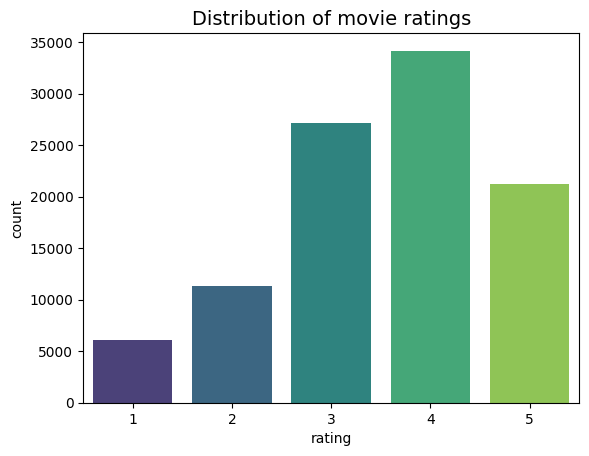

In [380]:
sns.countplot(x="rating", data=rating_df, palette="viridis")
plt.title("Distribution of movie ratings", fontsize=14)
plt.show()

In [381]:
print(f"Mean global rating: {round(rating_df['rating'].mean(),2)}.")
mean_ratings = rating_df.groupby('user')['rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(),2)}.")

Mean global rating: 3.53.
Mean rating per user: 3.59.


The distribution is left-skewed (biased towards higher ratings), suggesting that users tend to give higher ratings rather than lower ones. Users might be more inclined to rate movies they enjoyed, which could explain the abundance of 4 and 5-star ratings. So for cold start problem, movies with few ratings (especially low-rated ones) might not get recommended, highlighting the importance of content-based filtering or metadata use.

#### (4) Which movies are most frequently rated?

In [382]:
movie_df.columns

Index(['item', 'title', 'year', 'genres'], dtype='object')

In [384]:
movie_ratings = rating_df.merge(movie_df, left_on='item', right_on='item')
movie_ratings['title'].value_counts()[0:10]

title
Star Wars                 583
Contact                   509
Fargo                     508
Return of the Jedi        507
Liar Liar                 485
English Patient, The      481
Scream                    478
Toy Story                 452
Air Force One             431
Independence Day (ID4)    429
Name: count, dtype: int64

`Star Wars`, `Contact`, `Fargo` and `Return of the Jedi` have the most ratings.

#### (5) What are the lowest and highest rated movies?

In [386]:
mean_ratings = rating_df.groupby('item')[['rating']].mean()
lowest_rated = mean_ratings['rating'].idxmin()
movie_df[movie_df['item']==lowest_rated]

,item,title,year,genres
313,314,3 Ninjas: High Noon At Mega Mountain,1998,Action|Children's


In [387]:
rating_df[rating_df['item']==lowest_rated]

,user,item,rating,timestamp
2997,13,314,1,884538485
3425,2,314,1,888980085
13859,206,314,1,888179948
41251,609,314,1,886895941
78117,537,314,1,886029239


The lowest rated movie is `3 Ninjas: High Noon At Mega Mountain (1998)`. However, there are only 5 ratings which may be biased.

In [389]:
highest_rated = mean_ratings['rating'].idxmax()
movie_df[movie_df['item'] == highest_rated]

,item,title,year,genres
813,814,"Great Day in Harlem, A",1994,Documentary


In [390]:
rating_df[rating_df['item']==highest_rated]

,user,item,rating,timestamp
6519,13,814,5,886302261


The highest rated movie is `Great Day in Harlem, A (1994)` but there is only one rating which is not representative.

#### (6) Derive a less biased rating metric for a movie

From the analysis before, we find that some extreme mean rating are biased because of fewer ratings. We hope to find a metric that could help to better represent the average rating with varing number of ratings.

##### Bayesian Average

[Bayesian Average](https://en.wikipedia.org/wiki/Bayesian_average) is defined as:

$r_{i} = \frac{C \times m + \Sigma{\text{reviews}}}{C+N}$

where $C$ represents our confidence, $m$ represents our prior, and $N$ is the total number of reviews for movie $i$. In this case, our prior $m$ will be the average mean rating across all movies. By defintion, C represents "the typical data set size". Let's make $C$ be the average number of ratings for a given movie.

In [391]:
movie_stats = rating_df.groupby('item')['rating'].agg(['count', 'mean'])
movie_stats.head()

,count,mean
item,,
1,452,3.878319
2,131,3.206107
3,90,3.033333
4,209,3.550239
5,86,3.302326


In [392]:
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

print(f"Average number of ratings for a given movie: {C:.2f}")
print(f"Average rating for a given movie: {m:.2f}")

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return round(bayesian_avg, 3)

Average number of ratings for a given movie: 59.45
Average rating for a given movie: 3.08


In [393]:
bayesian_avg_ratings = rating_df.groupby('item')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['item', 'bayesian_avg']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='item')

In [394]:
movie_stats.head()

,item,count,mean,bayesian_avg
0,1,452,3.878319,3.785
1,2,131,3.206107,3.166
2,3,90,3.033333,3.050
3,4,209,3.550239,3.445
4,5,86,3.302326,3.210


In [397]:
movie_stats = movie_stats.merge(movie_df[['item', 'title']], left_on='item', right_on='item')
movie_stats.sort_values('bayesian_avg', ascending=False).head()

,item,count,mean,bayesian_avg,title
49,50,583,4.358491,4.240,Star Wars
317,318,298,4.466443,4.235,Schindler's List
63,64,283,4.445230,4.208,"Shawshank Redemption, The"
482,483,243,4.456790,4.185,Casablanca
11,12,267,4.385768,4.147,"Usual Suspects, The"


Using the Bayesian average, we see that `Star Wars`, `Schindler's List`, and `Shawshank Redemption` are the most highly rated movies. This result makes much more sense since these movies are also on the top list from many rating sites.

In [398]:
movie_stats.sort_values('bayesian_avg', ascending=True).head()

,item,count,mean,bayesian_avg,title
687,688,44,1.840909,2.551,Leave It to Beaver
686,687,69,2.188406,2.599,McHale's Navy
121,122,106,2.339623,2.604,"Cable Guy, The"
889,890,43,1.953488,2.605,Mortal Kombat: Annihilation
987,988,86,2.313953,2.625,"Beautician and the Beast, The"


### 4. A Glimpse at User dat

In [399]:
# Merge ratings with user data
user_df.rename(columns={'userid': 'user'}, inplace=True)
ratings_with_users = pd.merge(rating_df, user_df, on='user', how='left')

semantics_info = fetched_movies[['MovieLens_ID', 'Director', 'Actors']]
semantics_info = semantics_info.rename(columns={'MovieLens_ID': 'item', 'Actors': 'actors', 'Director': 'director'})

ratings_with_users = pd.merge(ratings_with_users, semantics_info, on='item', how='left')
                 
# Preview the merged data
print(ratings_with_users.head())

   user  item  rating  timestamp    age gender  occupation zipcode  \
0   196   242       3  881250949  45-49      M          20   55105   
1   186   302       3  891717742  35-44      F           6   00000   
2    22   377       1  878887116  25-34      M          20   40206   
3   244    51       2  880606923  25-34      M          19   80525   
4   166   346       1  886397596  45-49      M           3   55113   

            director                                             actors  
0         Jan Svěrák  Andrei Khalimon, Zdeněk Svěrák, Libuše Šafránk...  
1      Curtis Hanson  Guy Pearce, Russell Crowe, Kevin Spacey, Kim B...  
2                NaN                                                NaN  
3       Edward Zwick  Brad Pitt, Anthony Hopkins, Aidan Quinn, Julia...  
4  Quentin Tarantino  Pam Grier, Samuel L. Jackson, Robert De Niro, ...  


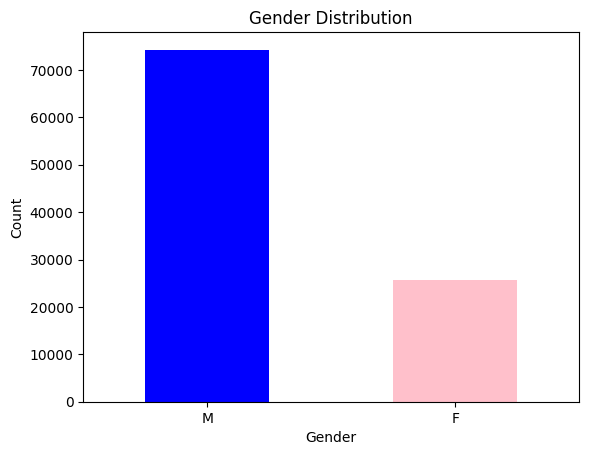

In [400]:
# Gender distribution
gender_counts = ratings_with_users['gender'].value_counts()
gender_counts.plot(kind='bar', color=['blue', 'pink'], title="Gender Distribution")
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

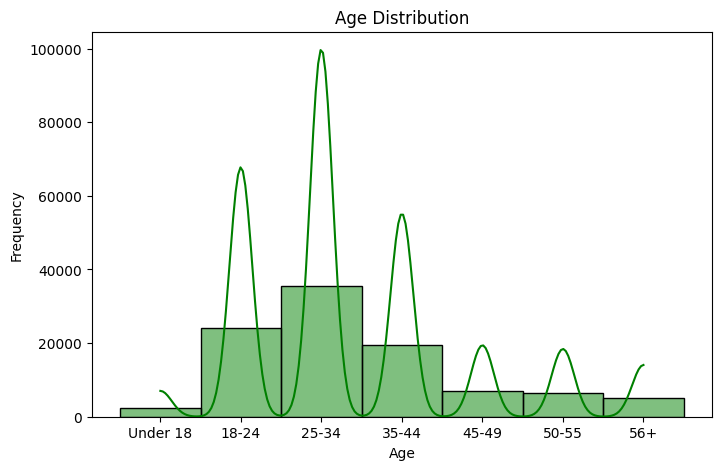

In [401]:
# Age distribution
plt.figure(figsize=(8, 5))
sns.histplot(ratings_with_users['age'], kde=True, bins=10, color='green')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [402]:
ratings_with_users.columns

Index(['user', 'item', 'rating', 'timestamp', 'age', 'gender', 'occupation',
       'zipcode', 'director', 'actors'],
      dtype='object')

/var/folders/9_/rwbmnd2917s2ynq8fvvlmq_80000gn/T/ipykernel_20827/645789862.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




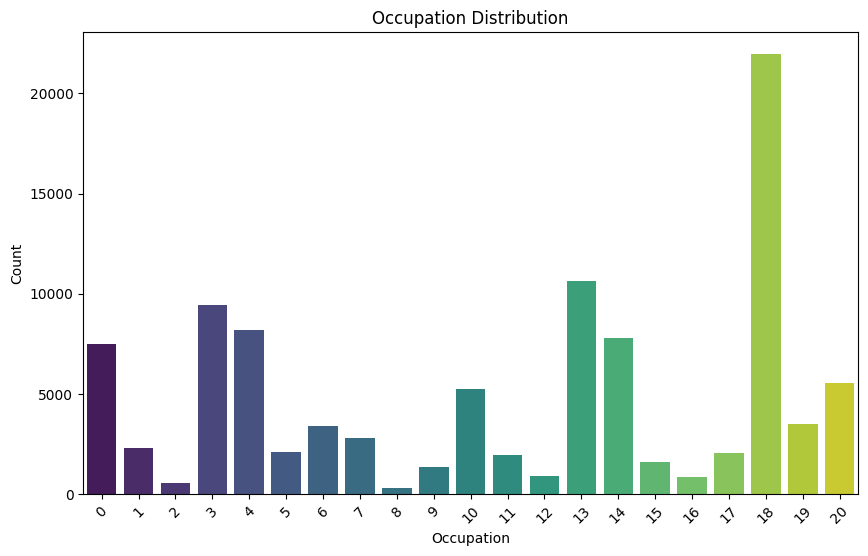

In [403]:
# Occupation distribution
plt.figure(figsize=(10, 6))
occupation_counts = ratings_with_users['occupation'].value_counts()
sns.barplot(x=occupation_counts.index, y=occupation_counts.values, palette="viridis")
plt.title('Occupation Distribution')
plt.xlabel('Occupation')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

OCCUPATIONS_100K = {
        "administrator": 0,
        "artist": 1,
        "doctor": 2,
        "educator": 3,
        "engineer": 4,
        "entertainment": 5,
        "executive": 6,
        "healthcare": 7,
        "homemaker": 8,
        "lawyer": 9,
        "librarian": 10,
        "marketing": 11,
        "none": 12,
        "other": 13,
        "programmer": 14,
        "retired": 15,
        "salesman": 16,
        "scientist": 17,
        "student": 18,
        "technician": 19,
        "writer": 20
    }

The bar chart clearly shows that students (occupation 18) are the largest group in this data set. 

In [404]:
# Number of ratings per user
ratings_per_user = ratings_with_users.groupby('user').size()

# Average rating per user
avg_rating_per_user = ratings_with_users.groupby('user')['rating'].mean()
print(avg_rating_per_user.describe())

# Most active users
most_active_users = ratings_per_user.sort_values(ascending=False).head(10)
print("Most active users:\n", most_active_users)


count    943.000000
mean       3.588191
std        0.445233
min        1.491954
25%        3.323054
50%        3.620690
75%        3.869565
max        4.869565
Name: rating, dtype: float64
Most active users:
 user
405    737
655    685
13     636
450    540
276    518
416    493
537    490
303    484
234    480
393    448
dtype: int64
